# Lab 3: Unsupervised Learning — KMeans, DBSCAN, PCA, and KMeans Variants

## Objective
In this lab, you will explore **unsupervised learning algorithms** using the **Wine dataset**.  
You’ll apply:
- **KMeans** and determine the optimal number of clusters.  
- **DBSCAN** for density-based clustering and anomaly detection.  
- **PCA** for dimensionality reduction and performance comparison.  
- **A research-based KMeans variant** (e.g., MiniBatchKMeans, Bisecting KMeans, Kernel KMeans).  

You will **quantitatively evaluate** each approach using metrics such as:
- Silhouette Score  
- Calinski–Harabasz Index  
- Davies–Bouldin Index  
- Runtime Efficiency  

---

## 1 - Setup and Data Loading (5pts)

In this section, you will:
1. Load the Wine dataset from `sklearn.datasets`.
2. Inspect the dataset’s structure (features, types, missing values).
3. Standardize the feature values to prepare for clustering.

```python
# TODO: Import necessary libraries
# Suggested imports:
# pandas, numpy, matplotlib, sklearn (datasets, preprocessing)

from sklearn.datasets import load_wine
import pandas as pd

# Load the dataset
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target

# Display the first few rows
df.head()

In [1]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np

wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target

df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


# 2 - Implement KMeans for k = 2 to 10 and compute inertia and silhouette scores

```python
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
```

# Plot Elbow and Silhouette Score


In [2]:
# Processing of data
#TODO: scale all numerical features using sklearn standard scaler
from sklearn.preprocessing import StandardScaler

feature_cols = [col for col in df.columns if col != 'target']
df_scaled = df.copy()

scaler = StandardScaler()
df_scaled[feature_cols] = scaler.fit_transform(df_scaled[feature_cols])


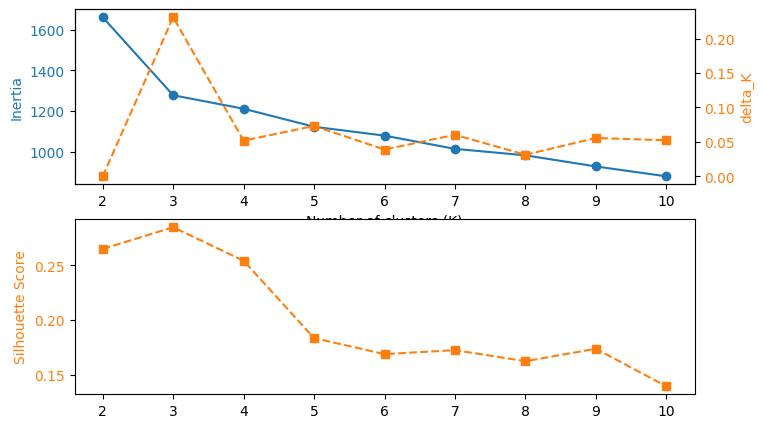

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

K = range(2, 11)
sil = []
wcss = []
delta_k = [0]
X = df_scaled[feature_cols].values

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    sil.append(silhouette_score(X, kmeans.predict(X)))

for k in range(1, len(wcss)):
    delta = (wcss[k-1] - wcss[k]) / wcss[k-1]
    delta_k.append(delta)

fig, ax1 = plt.subplots(2, figsize=(8,5))

color = 'tab:blue'
ax1[0].set_xlabel('Number of clusters (K)')
ax1[0].set_ylabel('Inertia', color=color)
ax1[0].plot(K, wcss, 'o-', color=color, label='Inertia')
ax1[0].tick_params(axis='y', labelcolor=color)

ax2 = ax1[0].twinx()
color = 'tab:orange'
ax2.set_ylabel('delta_K', color=color)
ax2.plot(K, delta_k, 's--', color=color, label='delta_K')
ax2.tick_params(axis='y', labelcolor=color)


color = 'tab:orange'
ax1[1].set_ylabel('Silhouette Score', color=color)
ax1[1].plot(K, sil, 's--', color=color, label='Silhouette Score')
ax1[1].tick_params(axis='y', labelcolor=color)


### Model result

- Silhouette score and inertia score plot indicates that the optimal number of clusters is 3. At **K = 3** the silhoutte score is maximized and the inertia plot exhibits a nice elbow angle.
- K = 3 also has the highest rate of change of inertia, which is an indication of a good number of clusters.

## Finalizing the model

In [4]:
K = 3
X = df_scaled[feature_cols].values
kmeans = KMeans(n_clusters=K, random_state=42)

df_scaled['KMeans - Cluster'] = kmeans.fit_predict(X)
print(f"Inertia error: {kmeans.inertia_}")
print(f"Silhouette score: {silhouette_score(X, df_scaled['KMeans - Cluster'])}")

Inertia error: 1277.928488844642
Silhouette score: 0.2848589191898987


# 3 - Implement DBSCAN with different parameter values

```python
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# Count clusters and outliers
```


#### DBSCAN Hyperparameter tuning
Since I don't have domain knowledge in this dataset I tried searching for methods in finding optimal epsilon and min_sample. I came across this answer in stackoverflow in heuristic way of estimating hyper parameters of DBSCAN https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan. This paper by SCHUBERT et al. is titled DBSCAN Revisited, Revisited:
Why and How You Should (Still) Use DBSCAN
- min_samples: The paper suggested that setting it to 2 * number of features is sometimes enough, but I will use it as my starting point and try to increase min_samples to (2 * number of features + 5)
- epsilon: Now this is a little more complicated, due to time constraint I didnt have time to fully internalize the paper (I found it Nov 6 10:00PM) so I just followed the most voted answer in the stackoverflow, to plot the sorted k-dist graph (through knn with n = 2 * dim - 1) and try to find the a visible "elbow", "knee", or "valley.

In [5]:
# starting point for eps - I got this from the stackoverflow article I pasted above.
from sklearn.neighbors import NearestNeighbors

def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


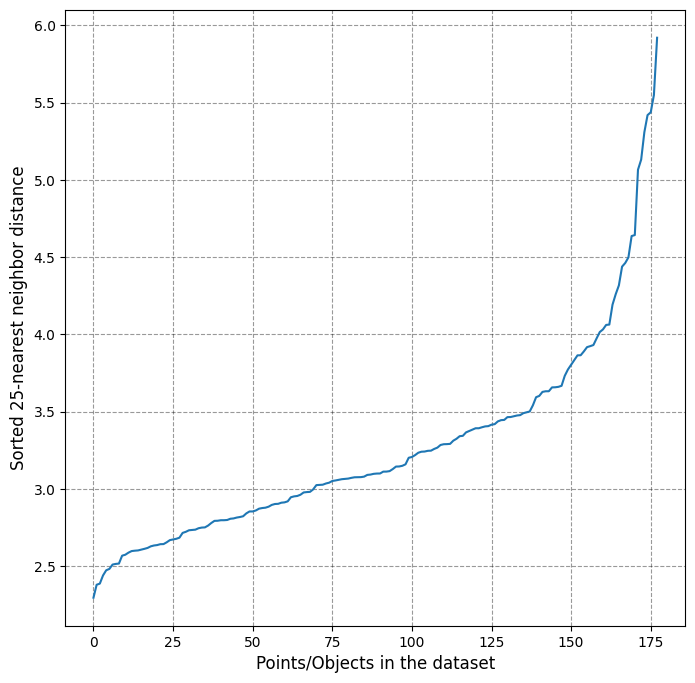

In [6]:
X = df_scaled[feature_cols]
k = 2 * X.values.shape[-1] - 1
get_kdist_plot(X=X.values, k=k)

Looks like there is an elbow/knee on distance = 3.5. With my own discretion, I will test DBSCAN model with eps (3.5 +- 0.5 with 0.1 step). As for the min_samples, there are articles saying that it should be greater than the number of features; so I used a range of number_features + 1 up to 2 * num_features. (the 2 * num_features was suggested by sanders et al as mentioned in the attached link to the paper)

- eps = 3.5 +- 0.5
- min_samples = (num_features + 1) to (2 * num_features)

In [7]:
from sklearn.cluster import DBSCAN
import numpy as np

num_features = len(feature_cols) # min_samples should be > num_features
epsilon = []
min_samp = []
num_outliers = []
num_clusters = []
sil_scores = []


epsilons = np.arange(3.5-0.5, 3.5+0.5, 0.1)
samples = range(num_features + 1, 2 * num_features + 1)
for sample in samples:
    for eps in epsilons:
        db = DBSCAN(eps=(eps), min_samples=sample)
        labels = db.fit_predict(X.values)

        noise_mask = labels == -1
        non_noise = labels[~noise_mask]
        clusters = len(set(non_noise))
        outliers = len(labels[noise_mask])

        if clusters >= 2:
            _, counts = np.unique(non_noise, return_counts=True)
            if np.all(counts >= 2):
                score = silhouette_score(X.iloc[~noise_mask], non_noise)
            else:
                score = np.nan
        else:
            score = np.nan

        epsilon.append(eps)
        min_samp.append(sample)
        num_outliers.append(outliers)
        num_clusters.append(clusters)
        sil_scores.append(score)

result = {
    'epsilon': epsilon,
    'min_samples': min_samp,
    'outliers': num_outliers,
    'clusters': num_clusters,
    'silhouette_scores': sil_scores
}

results = pd.DataFrame(result)
results[results['clusters']>=2]

,epsilon,min_samples,outliers,clusters,silhouette_scores
80,3.0,22,17,2,0.292725
90,3.0,23,18,2,0.295887
100,3.0,24,19,2,0.299325
110,3.0,25,19,2,0.299325
120,3.0,26,20,2,0.299368
121,3.1,26,14,2,0.281570


In [8]:
max_sil = results['silhouette_scores'].max()
results[results['silhouette_scores']==max_sil]

,epsilon,min_samples,outliers,clusters,silhouette_scores
120,3.0,26,20,2,0.299368


The table above shows the different variations of DBSCAN that has at least 2 clusters. All has acceptable number of outliers so I just chose the one with highest sil score.

In [9]:
# getting the model for visualization
db = DBSCAN(eps=3.0, min_samples=26)
df_scaled['dbs - Cluster'] = db.fit_predict(X.values)
df_scaled

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,KMeans - Cluster,dbs - Cluster
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009,0,2,0
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242,0,2,0
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148,0,2,0
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574,0,2,0
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.876275,2.974543,0.305159,0.301803,-0.332922,-0.985614,-1.424900,1.274310,-0.930179,1.142811,-1.392758,-1.231206,-0.021952,2,1,1
174,0.493343,1.412609,0.414820,1.052516,0.158572,-0.793334,-1.284344,0.549108,-0.316950,0.969783,-1.129518,-1.485445,0.009893,2,1,1
175,0.332758,1.744744,-0.389355,0.151661,1.422412,-1.129824,-1.344582,0.549108,-0.422075,2.224236,-1.612125,-1.485445,0.280575,2,1,1
176,0.209232,0.227694,0.012732,0.151661,1.422412,-1.033684,-1.354622,1.354888,-0.229346,1.834923,-1.568252,-1.400699,0.296498,2,1,1


#### DBSCAN visualization

Since we are dealing with more than two dimension and I don't know how to visualize more than 2 dimension, I opted to do a column pair visualization accross all combination of 13 features. This is rough and hard to understand.

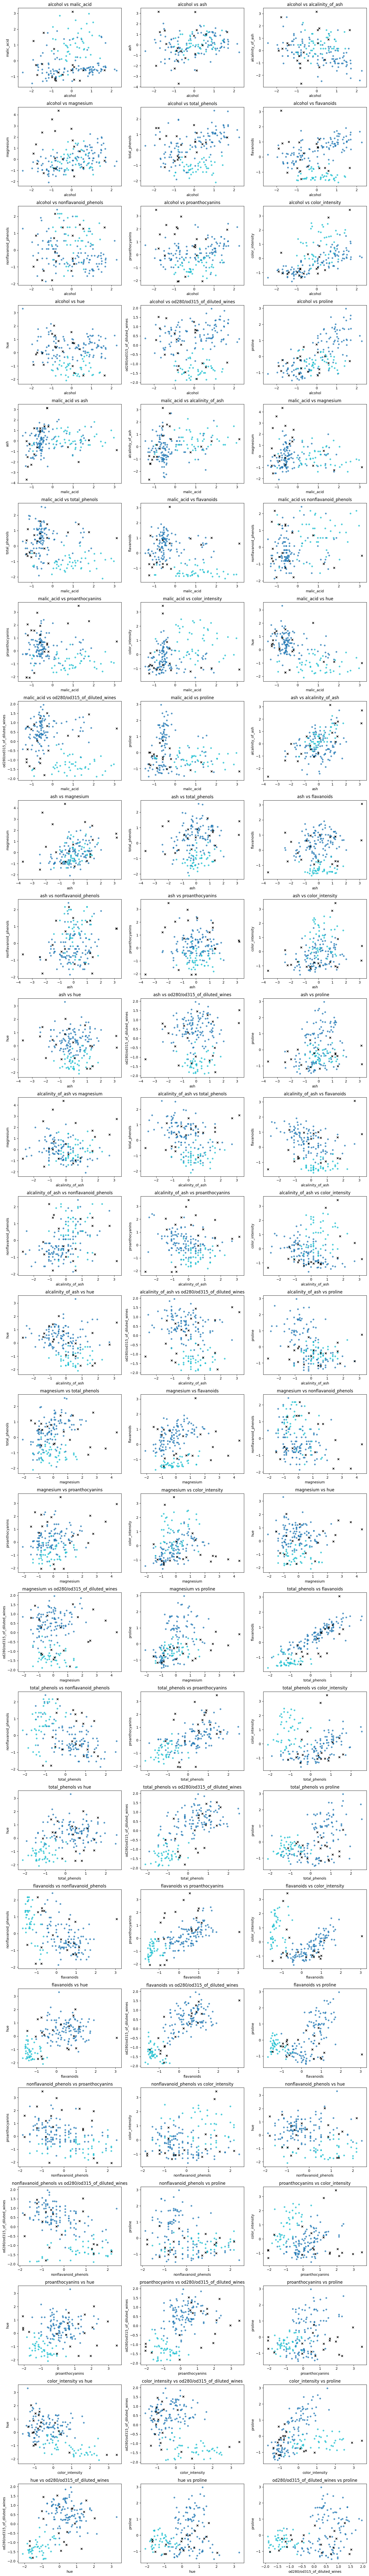

In [65]:
# TODO: Visualize DBSCAN results
import matplotlib.pyplot as plt
import itertools
import numpy as np

X = df_scaled[feature_cols]
labels = df_scaled['dbs - Cluster']

cols = X.columns
pairs = list(itertools.combinations(cols, 2))   # all feature pairs

ncols = 3
nrows = int(np.ceil(len(pairs) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 4))
axes = axes.flatten()

for ax, (xcol, ycol) in zip(axes, pairs):
    mask_core = labels != -1
    ax.scatter(X.loc[mask_core, xcol],
               X.loc[mask_core, ycol],
               c=labels[mask_core],
               cmap='tab10',
               s=15,
               alpha=0.7)
    mask_out = labels == -1
    ax.scatter(X.loc[mask_out, xcol],
               X.loc[mask_out, ycol],
               c='black',
               marker='x',
               s=25)
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    ax.set_title(f"{xcol} vs {ycol}")

# hide any unused axes if total pairs not multiple of ncols
for ax in axes[len(pairs):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Interpreting the visualization is a bit rough here since DBSCAN was trained with 13 dimensions but I visualize only for pairwise. Cluster separation are clear on some feature combination like hue vs proline, hue vs od280/od315_of_diluted wines, etc. The outliers are all over the place which is expected again since these plots only consists of pairwise combination.

In [21]:
# TODO: Compute and compare Silhouette Scores between KMeans and DBSCAN
kmeans_silhouette = silhouette_score(df_scaled[feature_cols].values, df_scaled['KMeans - Cluster'].values)
noise_mask = df_scaled['dbs - Cluster'] == -1
dbs_silhouette = silhouette_score(df_scaled[feature_cols][~noise_mask].values, df_scaled['dbs - Cluster'][~noise_mask].values)

print(f'KMeans silhouette score: {kmeans_silhouette}')
print(f'DBSCAN silhouette score: {dbs_silhouette}')
print(noise_mask.sum())

KMeans silhouette score: 0.2848589191898987
DBSCAN silhouette score: 0.299368067551432
20


#### KMeans vs DBSCAN

KMeans resulted in 3 clusters scored lower silhouette score than the DBSCAN of 2 clusters (the scores are close though). There are however 20 outliers in DBSCAN, excluding these outliers helped the silhouette score of DBSCAN. I tried some iterations of DBSCAN to get a higher silhouette score but small changes within epsilon and min_samples outside the heuristic approach was enough to get the number of outliers went out of hand. I got some variations where the number of outliers are 60 - 100 with high silhouette scores.

According to a simple google search, the acceptable silhouette score should be > 0.25. With this, both KMeans and DBSCAN clustering are acceptable.

These experiments shows that DBSCAN actually requires domain knowledge in choosing starting points of epsilon and min_samples and in this particular dataset.

Further analysis of clustered data coming from both models should be conducted to check which model (distance based or density based) is better in this dataset. My recommendation is to do a spiderplot to see if the clusters really makes sense.

# 4 - Apply PCA and visualize explained variance ratio

```python
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X)
```

In [12]:
# TODO: Determine number of components retaining >=90% variance and re-run clustering
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(df_scaled[feature_cols].values)
df_components = pd.DataFrame(
    pca.components_,
    columns=[f'PC{i+1}' for i in range(X.shape[1])]
)

df_components

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,0.144329,-0.245188,-0.002051,-0.239320,0.141992,0.394661,0.422934,-0.298533,0.313429,-0.088617,0.296715,0.376167,0.286752
1,0.483652,0.224931,0.316069,-0.010591,0.299634,0.065040,-0.003360,0.028779,0.039302,0.529996,-0.279235,-0.164496,0.364903
2,-0.207383,0.089013,0.626224,0.612080,0.130757,0.146179,0.150682,0.170368,0.149454,-0.137306,0.085222,0.166005,-0.126746
3,-0.017856,0.536890,-0.214176,0.060859,-0.351797,0.198068,0.152295,-0.203301,0.399057,0.065926,-0.427771,0.184121,-0.232071
4,-0.265664,0.035214,-0.143025,0.066103,0.727049,-0.149318,-0.109026,-0.500703,0.136860,-0.076437,-0.173615,-0.101161,-0.157869
5,0.213539,0.536814,0.154475,-0.100825,0.038144,-0.084122,-0.018920,-0.258594,-0.533795,-0.418644,0.105983,0.265851,0.119726
6,-0.056396,0.420524,-0.149171,-0.286969,0.322883,-0.027925,-0.060685,0.595447,0.372139,-0.227712,0.232076,-0.044764,0.076805
7,0.396139,0.065827,-0.170260,0.427970,-0.156361,-0.405934,-0.187245,-0.233285,0.368227,-0.033797,0.436624,-0.078108,0.120023
8,-0.508619,0.075283,0.307694,-0.200449,-0.271403,-0.286035,-0.049578,-0.195501,0.209145,-0.056218,-0.085828,-0.137227,0.575786
9,0.211605,-0.309080,-0.027125,0.052799,0.067870,-0.320131,-0.163151,0.215535,0.134184,-0.290775,-0.522399,0.523706,0.162116


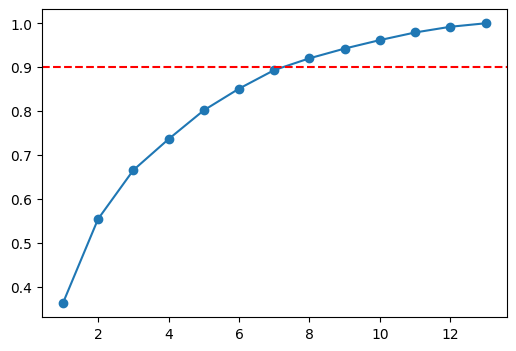

In [47]:
# TODO: Compute and tabulate performance metrics before vs after PCA using
explained_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.axhline(0.9, color='r', linestyle='--')
plt.show()

I will retain the first 7 columns since they retain more or less 90% of the variance ratio/ information

In [48]:
df_pca = pd.DataFrame(X_pca, columns=[f'col-{col+1}' for col in range(X_pca.shape[1])])
cols = ['col-1', 'col-2', 'col-3', 'col-4', 'col-5', 'col-6', 'col-7']

#### KMeans after PCA

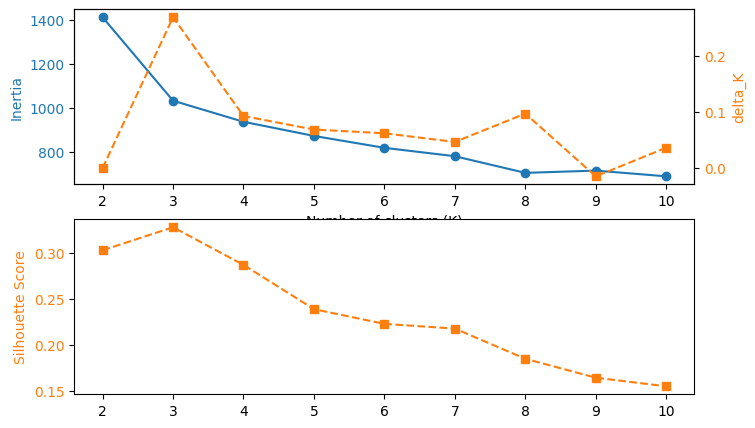

In [49]:
# Performing KMeans clustering
K = range(2, 11)
sil = []
wcss = []
delta_k = [0]
X = df_pca[cols]

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    sil.append(silhouette_score(X.values, kmeans.predict(X)))

for k in range(1, len(wcss)):
    delta = (wcss[k-1] - wcss[k]) / wcss[k-1]
    delta_k.append(delta)

fig, ax1 = plt.subplots(2, figsize=(8,5))

color = 'tab:blue'
ax1[0].set_xlabel('Number of clusters (K)')
ax1[0].set_ylabel('Inertia', color=color)
ax1[0].plot(K, wcss, 'o-', color=color, label='Inertia')
ax1[0].tick_params(axis='y', labelcolor=color)

ax2 = ax1[0].twinx()
color = 'tab:orange'
ax2.set_ylabel('delta_K', color=color)
ax2.plot(K, delta_k, 's--', color=color, label='delta_K')
ax2.tick_params(axis='y', labelcolor=color)


color = 'tab:orange'
ax1[1].set_ylabel('Silhouette Score', color=color)
ax1[1].plot(K, sil, 's--', color=color, label='Silhouette Score')
ax1[1].tick_params(axis='y', labelcolor=color)

Based on the plot above, K = 3 is the optimal clusters as it has the highest delta K that's within the first elbow. K=3 also exhibits the best silhouette score in the first 10 iterations of KMeans.

In [50]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_pca['KMeans - Clusters'] = kmeans.fit_predict(df_pca.values)

#### DBSCAN after PCA

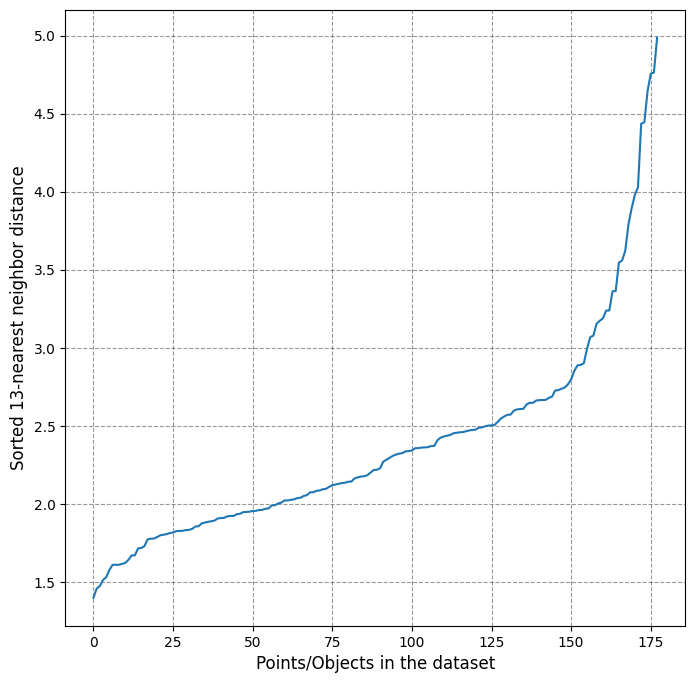

In [51]:
# Choosing eps and min_samples
X = df_pca[cols]
k = 2 * X.values.shape[-1] - 1
get_kdist_plot(X=X.values, k=k)

Same thought process.

eps = 2.7 +- 0.5
min_samples = num_features + 1 to 2 * num_features

In [52]:
from sklearn.cluster import DBSCAN
import numpy as np

X = df_pca[cols]
num_features = len(cols)
epsilon = []
min_samp = []
num_outliers = []
num_clusters = []
sil_scores = []


epsilons = np.arange(2.7-0.5, 2.7+0.5, 0.1)
samples = range(num_features + 1, 2 * num_features + 1)
for sample in samples:
    for eps in epsilons:
        db = DBSCAN(eps=(eps), min_samples=sample)
        labels = db.fit_predict(X.values)

        noise_mask = labels == -1
        non_noise = labels[~noise_mask]
        clusters = len(set(non_noise))
        outliers = len(labels[noise_mask])

        if clusters >= 2:
            _, counts = np.unique(non_noise, return_counts=True)
            if np.all(counts >= 2):
                score = silhouette_score(X.iloc[~noise_mask], non_noise)
            else:
                score = np.nan
        else:
            score = np.nan

        epsilon.append(eps)
        min_samp.append(sample)
        num_outliers.append(outliers)
        num_clusters.append(clusters)
        sil_scores.append(score)

result = {
    'epsilon': epsilon,
    'min_samples': min_samp,
    'outliers': num_outliers,
    'clusters': num_clusters,
    'silhouette_scores': sil_scores
}

results = pd.DataFrame(result)
results[results['clusters'] >= 2]

,epsilon,min_samples,outliers,clusters,silhouette_scores
10,2.2,9,24,2,0.344217
20,2.2,10,26,2,0.360389
30,2.2,11,28,2,0.364794
40,2.2,12,31,2,0.365131
41,2.3,12,23,2,0.349307
50,2.2,13,33,2,0.365474
51,2.3,13,23,2,0.349307
60,2.2,14,33,2,0.365474
61,2.3,14,24,2,0.353481


The silhouette scores of clusters = 2 are near with each other so let's just minimize the number of outliers in choosing parameters for DBSCAN.

- epsilon = 2.2
- min_samples = 10
- num_outliers = 26 / 117 = 22%

In [54]:
db = DBSCAN(eps=2.2,  min_samples=10)
df_pca['DBSCAN - Clusters'] = db.fit_predict(df_pca[cols].values)

In [56]:
kmeans_silhouette = silhouette_score(df_pca[cols].values, df_pca['KMeans - Clusters'].values)

noise_mask = df_pca['DBSCAN - Clusters'] == -1

dbs_silhouette = silhouette_score(df_pca[cols][~noise_mask].values, df_pca['DBSCAN - Clusters'][~noise_mask].values)

print(f'KMeans silhouette score: {kmeans_silhouette}')
print(f'DBSCAN silhouette score: {dbs_silhouette}')

KMeans silhouette score: 0.32763517224028216
DBSCAN silhouette score: 0.360389477086761


Performing PCA before clustering significantly increases the silhouette scores for both DBSCAN and KMeans. Interpreting the df_pca is out of my skillset for now but my suggestion in checking which model is better. Import the cluster results to the original data and thoroughly analyze each grouped data to see which model makes more sense this dataset.

# 5 - Clustering Variations

a. Research on a variation of KMeans
b. Implement the variation and repeat process in item #2


## Density K-Means++

I've read this paper https://link.springer.com/article/10.1007/s10994-021-06021-7 that benchmark different KMeans centroid initialization. Based on their testing, D-KMeans or Density K-Means++ performed the best.

It was first implemented by Nidheesh et al. Since their implementation code (https://github.com/nidheesh-n/dkmpp/tree/master) is written in R, I had to use chatGPT to help breakdown their implementation.


## Steps in implementing Density K-Means++ (as per their R implementation)
1. Compute pairwise Euclidean distances between all samples. Then scale the distances [0, 1] range by simply dividing them by the maximum pairwise distance.
2. Build a Minimum Spanning Tree on the distance graph. Then define epsilon roughly the 75th percentile + 3 * IQR (should not increase the max edge)
3. Local density computation.
4. min-max normalization of local densities.
5. Centroid selection based on the points with high density.
6. Then do a traditional KMeans with initial centroid that was derived from steps 1-6.

In [35]:
# Using the previous normalized data
X = df_scaled[feature_cols].values
k = 3

In [36]:
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.stats import iqr

#### 1. Euclidean pairwise distances

In [37]:
M = cdist(X, X, metric="euclidean").astype(float)
M_max = M.max()
if M_max > 0:
    M = M / M_max  # scale
print(M.shape, float(M.min()), float(M.max()))

(178, 178) 0.0 1.0


#### 2. MST-based epsilon.
I have yet to study minimum spanning tree so I searched and used gen AI for the implementation

In [38]:
mst = minimum_spanning_tree(M)      # sparse CSR matrix of MST
edge_lengths = mst.data             # array of MST edge weights (~ n-1)

if edge_lengths.size > 0:
    eps_candidate = 3.0 * iqr(edge_lengths) + np.quantile(edge_lengths, 0.75)
    eps = float(min(edge_lengths.max(), eps_candidate))
else:
    # degenerate case (e.g., all points identical)
    pos = M[M > 0]
    eps = float(pos.min()) if pos.size else float(np.finfo(float).eps)

# final guard
if not np.isfinite(eps) or eps <= 0:
    pos = M[M > 0]
    eps = float(pos.min()) if pos.size else float(np.finfo(float).eps)

print("epsilon (radius) =", eps)

epsilon (radius) = 0.35216963009674035


#### 3. Local density ρ with ε-neighborhood (exponential kernel)

In [39]:
rho = np.zeros(X.shape[0], dtype=float)

for i in range(X.shape[0]):
    nbrs = np.where(M[:, i] <= eps)[0]
    nbrs = nbrs[nbrs != i]               # exclude self
    if nbrs.size:
        rho[i] = np.sum(np.exp(-M[i, nbrs] / eps))

print("rho stats -> min:", float(rho.min()), "max:", float(rho.max()))

# normalize rho
rho_min, rho_max = float(rho.min()), float(rho.max())
if rho_max > rho_min:
    rho = (rho - rho_min) / (rho_max - rho_min)
else:
    rho = np.zeros_like(rho)

rho stats -> min: 0.3716960059959047 max: 43.57336933125


#### 4. Finding centroids. set the first centroid as the densest point

In [40]:
# first centroid
p = int(np.argmax(rho))   # index of highest density
C = [p]                   # list of chosen centroid indices (0-based)

# this is just helpers like the one in the R code
mind2cent = np.full(X.shape[0], np.inf)   # nearest distance to any chosen center so far
prospect  = np.zeros(X.shape[0], float)   # rho * nearest_distance score

# iteratively pick the remaining centroid
while len(C) < k:
    # update nearest distance using the most recently added center p
    mind2cent = np.minimum(mind2cent, M[:, p])

    # prospectiveness = density × nearest distance
    prospect = rho * mind2cent

    # avoid reselecting already chosen centers
    prospect[np.array(C, dtype=int)] = -np.inf

    # pick next center
    p = int(np.argmax(prospect))
    C.append(p)

print("chosen center indices (0-based):", C)

chosen center indices (0-based): [81, 162, 5]


#### 5. Run the traditional KMeans++ using the initial centroids

In [41]:
init_centers = X[C]
km = KMeans(n_clusters=k, init=init_centers, n_init=1, max_iter=50)
df_scaled['DKMPP - Clusters'] = km.fit_predict(X)

In [ ]:
dkmpp_silhouette = silhouette_score(X, df_scaled['DKMPP - Clusters'])
print(f'KMeans score: {kmeans_silhouette}')
print(f'Density KMeans score: {dkmpp_silhouette}')

KMeans score: 0.2848589191898987
Density KMeans score: 0.28594199657074876


Density KMeans++ actually performed a little bit better than the traditional KMeans in this case. The heuristic way of initializing centroid actually worked!

# Guide Questions

### 1. Research on another way to determine / objectify the results of clustering aside from silhouette score. If it just so happens that these metrics disagree on which cluster count is the “best”, which metric should you trust more and why?

Testing using calinski_harabasz_score instead of silhouette score. Using the pca kmeans and dbscan implementation

In [62]:
from sklearn.metrics import calinski_harabasz_score
noise_mask = df_pca['DBSCAN - Clusters'] == -1
db_score = calinski_harabasz_score(df_pca[cols][~noise_mask], df_pca['DBSCAN - Clusters'][~noise_mask])
kmeans_score = calinski_harabasz_score(df_pca[cols], df_pca['KMeans - Clusters'])

print(f'KMeans: {kmeans_score}')
print(f'DBSCAN: {db_score}')

KMeans: 87.70699571068275
DBSCAN: 89.18676399907716


source: https://permetrics.readthedocs.io/en/latest/pages/clustering/CHI.html

Equation for calinski_harabasz_score is

$$
CH = \frac{B}{W} \times \frac{n - k}{k - 1}
$$

Where
- B: sum of distances between cluster centroids and the overall dataset mean, weighted by the number of data points per cluster
- W: the sum of squared distances between data points and their respective cluster centroids
- n: number of data points
- k: number of clusters

According to the site, the higher the CH is the better. I do agree that the higher is better since when we increase B then the distances between centroids of clusters are high, which means there are clear separation between clusters. There are no specific range values of this like silhouette score, it just tells you which model/parameters are better so silhouette score is still the better and more trustworthy for me.

Both silhouette and CH says that DBSCAN's score is a little bit better in terms of cluster distinction.

### 2. After applying PCA, the number of features was reduced while retaining ≥90% of variance.

Since this is not a question, I just followed number 2 as my guide in retaining the number of features in PCA implementation.

### 3. Did your clustering performance improve or degrade after PCA — and how can this be mathematically explained using the concepts of variance preservation?

After PCA, both KMeans and DBSCAN clustering improved in terms of silhouette scores.

My understanding here is that, distance based alrogirthms performs poorly when dealing with high dimensional data. KMeans and DBSCAN in particular operates by calculating the "minimum" distances between points or centroids. Let's have an example of calculating Euclidean distance from one point to another of an N dimensional vector space.

$$
d(p, q) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + \cdots + (p_n - q_n)^2}
$$

Evidently, increasing N will futher increase the value of d. If we have high enough N, the distances between any two points will become more and more similar which will mostly decrease the silhouette score or render it ineffective in evaluating clusters. The silhouette score should decrease since **a** will be relatively close to **b**.

$$
s = \frac{b - a}{\max(a, b)}
$$

Why was PCA effective? In this experiment, components comprising the 90% of variances were retained. This resulted in eliminating 4/13 dimensions while retaining majority of the information. As explained, increasing dimension have negative effect on distance based algorithms, reducing dimensions on the other hand should theoretically have positive effect--in this case it did.

### 4. Using your metrics, identify a specific case in the Wine dataset where DBSCAN fails but KMeans succeeds (or vice versa).

DBSCAN is really hard to train for this wine dataset. The data requires high epsilons (3.0 for vanilla and 2.2 PCA reduced) to even form multiple clusters. I had tests where a little bit of movement from epsilon and min_samples yielded an unreadable model due to either incredibly high outlier count or yielding only one cluster.

KMeans on the other hand was easy to train for this dataset, just a straightforward iteration and find the optimal K using elbow method (which is incredibly defined by the way). Yes DBSCAN yielded higher score but yielded only two clusters with acceptable but still high number of outliers.

### 5. Your chosen KMeans variant was designed to improve either speed, initialization stability, or accuracy. Which metric most convincingly proves that your variant outperformed standard KMeans — and under what dimensionality and runtime trade-offs?

Density KMeans++ or DKMPP improved the silhouette score a bit, which I think in larger dataset is not worth the trouble in using if the improvement is negligible at the cost of additional complexity.

In my process. I still used the traditional kmeans to obtain the optimal number of K since DKMPP requires you to have a number of K to determine all the appropriate centroids/points with high density. The heuristic way of finding the initial centroid itself has its own run time on top of that the traditional KMeans to find optimal K, and the KMeans training with initialized centroids.

DKMPP complexity is dominated by O(n^2), while traditional sklearn kmeans (kmpp) has a run time of O(knd).

If I have more time and multiple dataset, I can do a hypothesis testing to find if the DKMPP gives significant improvement on metrics over the traditional KMeans. But for this dataset, DKMPP is not worth the trouble.
